In [1]:
!nvidia-smi

Fri Dec 15 07:24:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:15:00.0 Off |                    0 |
| N/A   27C    P0              40W / 300W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Packages

In [2]:
import os
import sys
sys.path.append("../src")

In [3]:
%load_ext autoreload
%autoreload 2

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
from einops import repeat, rearrange, reduce

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [24]:
import config
from dataloader import BEDataset, BEDataModule

from rt1 import RT1Encoder, RT1Decoder
from transformer import make_attn_mask, EmbeddingLayer, DecoderLayer, TransformerDecoder
from utils.model_utils import TextEncoder, fetch_sample_from_batch, plot_attention, get_seq_len


## Data module

In [6]:
dm = BEDataModule()
dm.setup()

INFO:root:Training on 3808 samples.
INFO:root:Validating on 700 samples.
INFO:root:Testing on 250 samples.


Total # examples: 4758


In [7]:
%%time
batch = next(iter(dm.train_dataloader()))
print(batch.keys())
batch["in_state"].shape

/ocean/projects/cis230036p/cmanouan/miniconda3/envs/smf_be/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dict_keys(['sample_id', 'in_state', 'action_desc', 'motor_cmd'])
CPU times: user 602 ms, sys: 646 ms, total: 1.25 s
Wall time: 22.6 s


torch.Size([32, 3, 288, 288])

In [8]:
input_ids=batch["action_desc"]["ids"].cuda()
attn_mask=batch["action_desc"]["mask"].cuda()
token_type_ids=batch["action_desc"]["token_type_ids"].cuda()
imgs=batch["in_state"].cuda()
decoder_inp=batch["motor_cmd"]["decoder_inp_ids"].cuda()

decoder_inp.shape

torch.Size([32, 16])

## Encoder

In [9]:
encoder = RT1Encoder(
    cnn_bacnbone="resnet18", 
    num_res_blocks=3, 
    freeze_cnn_backbone=True
).to(config.DEVICE)

summary(model=encoder, col_names=["num_params", "trainable"])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─FeatureListNet: 3-4                              (1

In [10]:
text_enc_h_state, learned_tokens, _ = encoder(
    input_ids=input_ids,
    attn_mask=attn_mask,
    token_type_ids=token_type_ids,
    imgs=imgs
)

learned_tokens.shape, text_enc_h_state.shape

(torch.Size([32, 48, 512]), torch.Size([32, 16, 512]))

In [11]:
pooled = reduce(learned_tokens, 'b (f n) d -> b n d', 'mean', f = 6)

pooled.shape

torch.Size([32, 8, 512])

## Decoder

### Test decoder Layer

In [12]:
# dec_layer = DecoderLayer().cuda()
# print(dec_layer)
# summary(dec_layer)

In [13]:
target_embedding = EmbeddingLayer().cuda()

outp = decoder_inp
outp_emb = target_embedding(outp)

outp_emb.shape

torch.Size([32, 16, 512])

In [14]:
# seq_len = get_seq_len(outp[0])

# # outp[0], seq_laen 

In [15]:
# attn_mask = make_attn_mask()

# attn_mask.float()

In [16]:
# dec_out, self_attn_w, cross_attn_w = dec_layer(
#     dec_in=outp_emb, 
#     enc_out=learned_tokens
# )

# dec_out.shape, self_attn_w.shape, cross_attn_w.shape

In [17]:
# plot_attention(self_attn_w)

In [18]:
# plot_attention(cross_attn_w)

### Test decoder 

In [19]:
dec = TransformerDecoder(num_layers=1).cuda()
print(dec)
summary(model=dec)

TransformerDecoder(
  (emb_layer): EmbeddingLayer(
    (tok_emb): Embedding(52, 512, padding_idx=0)
    (pos_emb): PositionalEncoding()
    (drop_out): Dropout(p=0.2, inplace=False)
  )
  (layers): ModuleList(
    (0): DecoderLayer(
      (self_attention): MultiHeadAttention(
        (attention): ScaleDotProductAttention(
          (softmax): Softmax(dim=-1)
        )
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=True)
        (w_v): Linear(in_features=512, out_features=512, bias=True)
        (w_concat): Linear(in_features=512, out_features=512, bias=True)
      )
      (norm1): LayerNorm()
      (dropout1): Dropout(p=0.2, inplace=False)
      (cross_attention): MultiHeadAttention(
        (attention): ScaleDotProductAttention(
          (softmax): Softmax(dim=-1)
        )
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=

Layer (type:depth-idx)                             Param #
TransformerDecoder                                 --
├─EmbeddingLayer: 1-1                              --
│    └─Embedding: 2-1                              26,624
│    └─PositionalEncoding: 2-2                     --
│    └─Dropout: 2-3                                --
├─ModuleList: 1-2                                  --
│    └─DecoderLayer: 2-4                           --
│    │    └─MultiHeadAttention: 3-1                1,050,624
│    │    └─LayerNorm: 3-2                         1,024
│    │    └─Dropout: 3-3                           --
│    │    └─MultiHeadAttention: 3-4                1,050,624
│    │    └─LayerNorm: 3-5                         1,024
│    │    └─Dropout: 3-6                           --
│    │    └─FeedForwardLayer: 3-7                  1,050,112
│    │    └─LayerNorm: 3-8                         1,024
│    │    └─Dropout: 3-9                           --
Total params: 3,181,056
Trainable params: 3

In [20]:
dec_out, self_attn_w, cross_attn_w = dec(
    dec_in=outp, 
    enc_out=learned_tokens
)

dec_out.shape, self_attn_w.shape, cross_attn_w.shape

(torch.Size([32, 16, 512]),
 torch.Size([32, 8, 16, 16]),
 torch.Size([32, 8, 16, 48]))

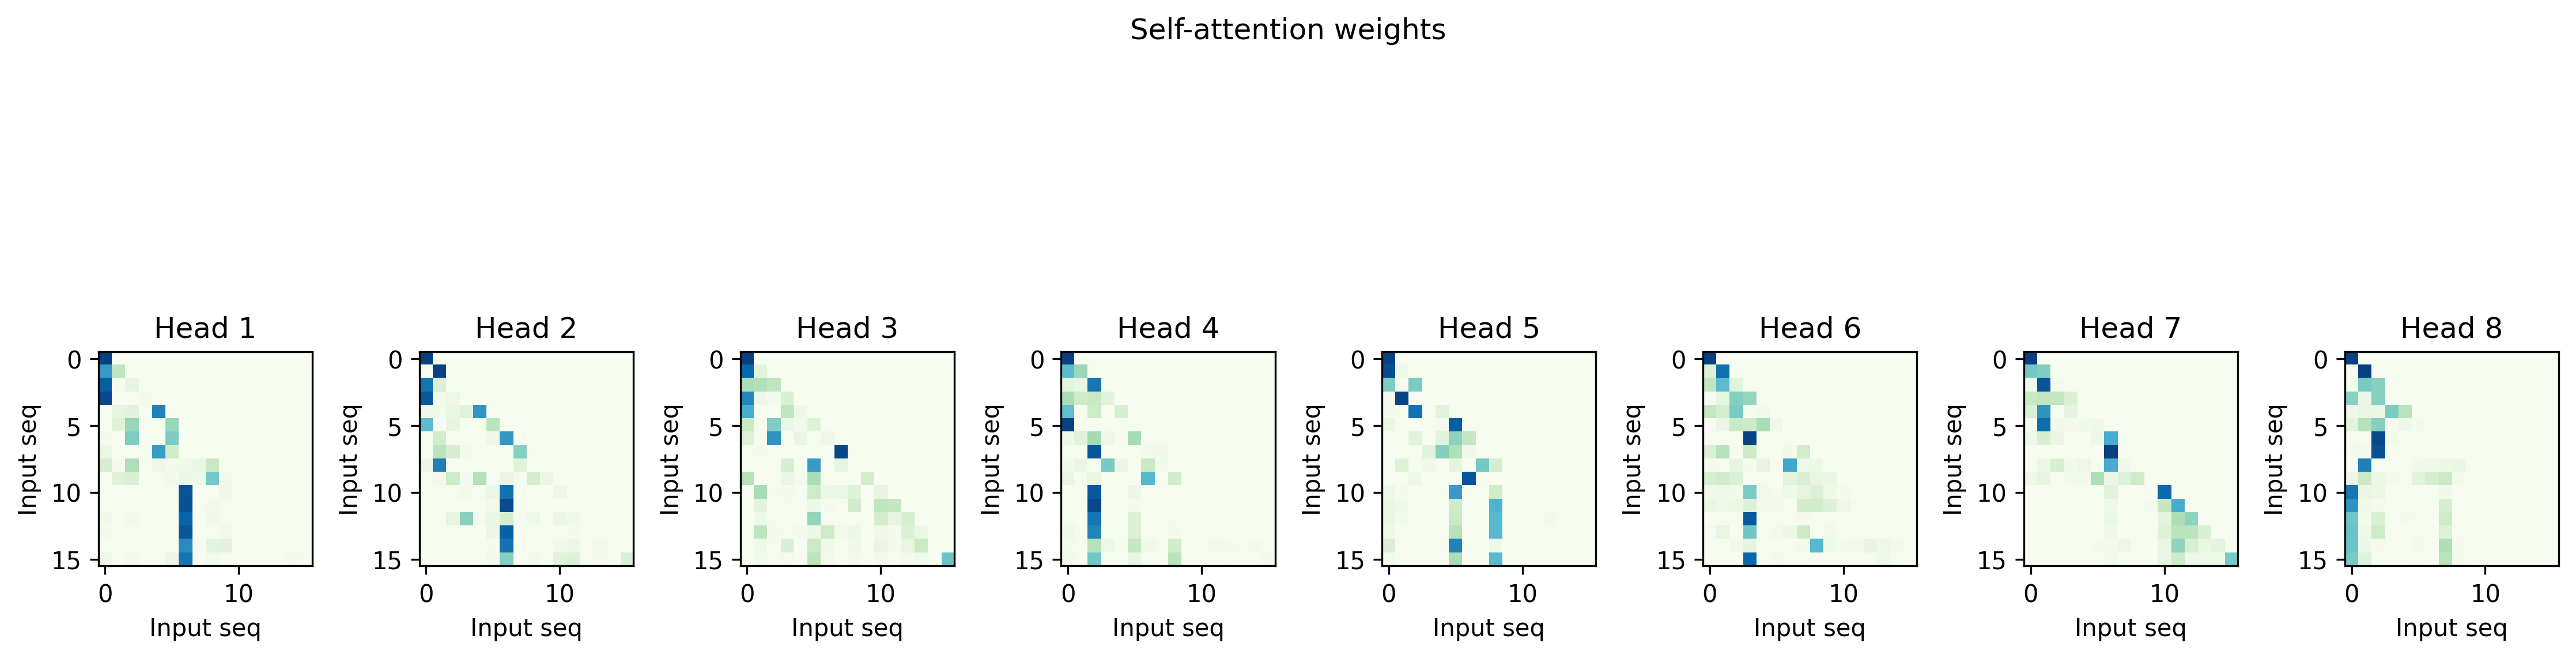

In [21]:
plot_attention(self_attn_w)

In [22]:
self_attn_w[0, 0, 4]

tensor([3.0791e-04, 9.7101e-02, 1.1763e-01, 3.7046e-04, 7.8459e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)

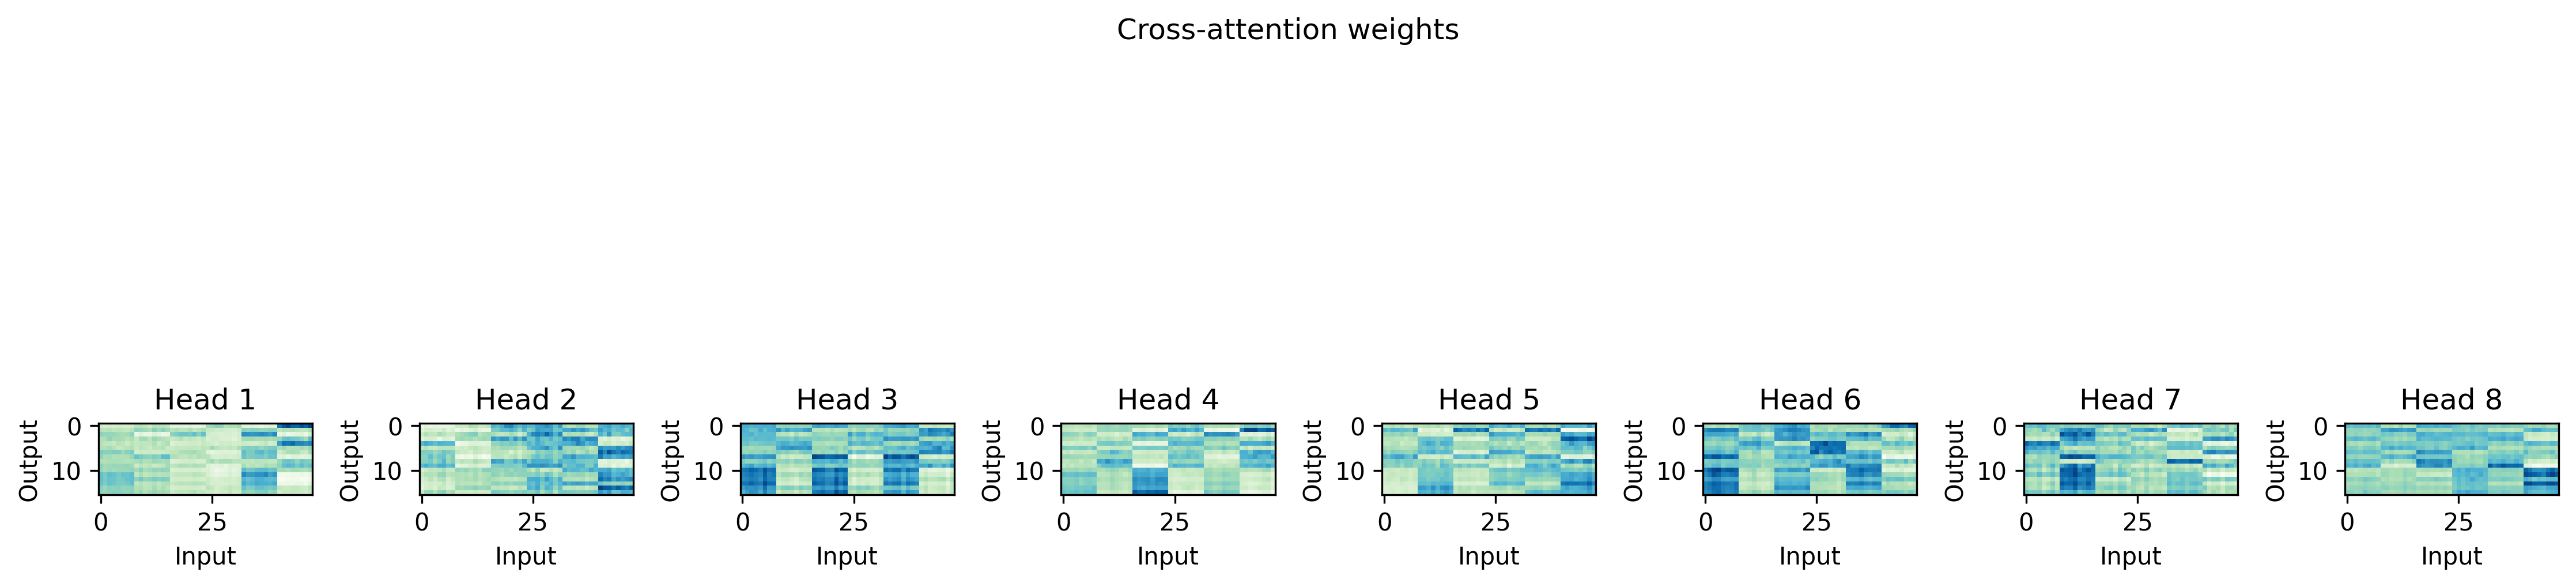

In [23]:
plot_attention(cross_attn_w)

## RT1 Decoder

In [26]:
decoder = RT1Decoder().cuda()
print(decoder)
summary(decoder)

RT1Decoder(
  (transformer): TransformerDecoder(
    (emb_layer): EmbeddingLayer(
      (tok_emb): Embedding(52, 512, padding_idx=0)
      (pos_emb): PositionalEncoding()
      (drop_out): Dropout(p=0.2, inplace=False)
    )
    (layers): ModuleList(
      (0): DecoderLayer(
        (self_attention): MultiHeadAttention(
          (attention): ScaleDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (w_concat): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm()
        (dropout1): Dropout(p=0.2, inplace=False)
        (cross_attention): MultiHeadAttention(
          (attention): ScaleDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_features=512, out_features=512

Layer (type:depth-idx)                                  Param #
RT1Decoder                                              --
├─TransformerDecoder: 1-1                               --
│    └─EmbeddingLayer: 2-1                              26,624
│    │    └─Embedding: 3-1                              26,624
│    │    └─PositionalEncoding: 3-2                     --
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─DecoderLayer: 3-4                           3,154,432
├─LayerNorm: 1-2                                        1,024
├─ActionGenerator: 1-3                                  --
│    └─Sequential: 2-3                                  --
│    │    └─Linear: 3-5                                 26,676
│    │    └─Dropout: 3-6                                --
Total params: 3,235,380
Trainable params: 3,235,380
Non-trainable params: 0

In [29]:
dec_out, self_attn_w, cross_attn_w = decoder(
    inp=outp, 
    encoder_out=learned_tokens
)

dec_out.shape, self_attn_w.shape, cross_attn_w.shape

(torch.Size([32, 16, 52]),
 torch.Size([32, 8, 16, 16]),
 torch.Size([32, 8, 16, 48]))

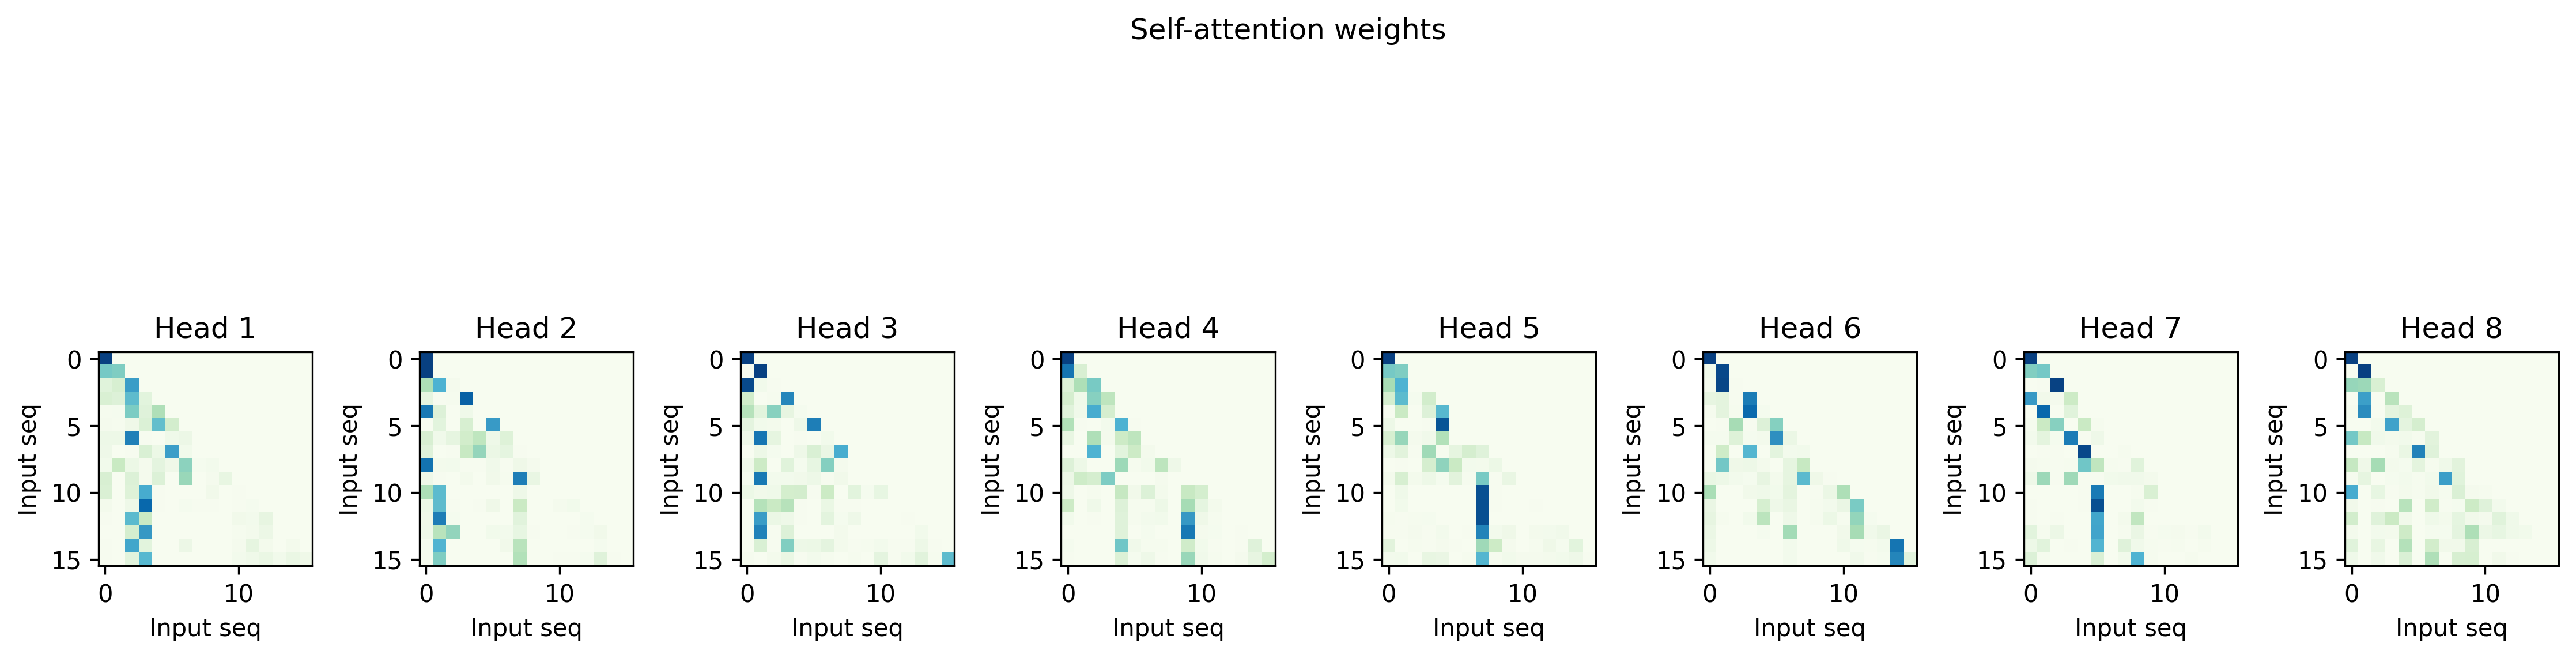

In [30]:
plot_attention(self_attn_w)

In [ ]:
plot_attention(cross_attn_w)